In [1]:
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from random import shuffle
#from scipy.misc import imresize
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = r'd:\ML\data\f'
IMAGE_DIR  = os.path.join(DATA_DIR, 'images', "out")
VAL_DATA_DIR = os.path.join(DATA_DIR, 'images', "validation")
MAX_THUMB_SIZE=(32,80)

In [3]:

image_dir = IMAGE_DIR 
def create_all_triplets(image_dir):
    img_full_list=[]
    for folder in  [f.name for f in os.scandir(image_dir) if f.is_dir()]:        
        for img_file in [f.name for f in os.scandir(os.path.join(image_dir, folder)) if f.is_file()]:
            img_full_list.append((folder, img_file))
    pos_triplets = ([p for p in itertools.combinations(img_full_list, 2) if p[0][0] == p[1][0]])
    neg_triplets = ([p for p in itertools.combinations(img_full_list, 2) if p[0][0] != p[1][0]])

    #TODO: remove hardcode
    all_players = {t[0] for t in img_full_list}
    purple = {'Александр _11','Алихан Абдулаев _5', 'Дмитрий Морозов _18','Максим Аникеев _33','Максим Камышик _29','Михаил Невинный _38','Николай Новик _2','Сергей Стрельцов _23','Тигран _6'}
    green={'Александр Кулявцев _12','Араз Эйвазов _13','Виталий Притулин _10','Илья _22','Сандро Никурадзе _7','Шахин Абулов _4'}
    white={'Валера _44','Дмитрий Витвицкий _21','Иван Кошелапов _19','Игорь Дёмин _32','Павел _43'}
    colored = all_players - purple - green - white
    teams=[purple, green,white,colored]    
    new_neg_triplets=[]
    for team in teams:
        new_neg_triplets.extend([(p1, p2) for p1, p2 in neg_triplets if p1[0] in team and p2[0] in team])
    neg_triplets = new_neg_triplets   
    
    return pos_triplets, neg_triplets, img_full_list
pos_triplets, neg_triplets, img_full_list = create_all_triplets(image_dir)
len(pos_triplets), len(neg_triplets)

(3990, 23786)

In [146]:
len ([p for p in itertools.combinations(img_full_list, 2) if p[0][0] != p[1][0]])

134846

In [4]:
all_players = {t[0] for t in img_full_list}
purple = {'Александр _11','Алихан Абдулаев _5', 'Дмитрий Морозов _18','Максим Аникеев _33','Максим Камышик _29','Михаил Невинный _38','Николай Новик _2','Сергей Стрельцов _23','Тигран _6'}
green={'Александр Кулявцев _12','Араз Эйвазов _13','Виталий Притулин _10','Илья _22','Сандро Никурадзе _7','Шахин Абулов _4'}
white={'Валера _44','Дмитрий Витвицкий _21','Иван Кошелапов _19','Игорь Дёмин _32','Павел _43'}
colored = all_players - purple - green - white
teams=[purple, green,white,colored]

In [15]:
neg_triplets = ([p for p in itertools.combinations(img_full_list, 2) if p[0][0] != p[1][0]] )
new_neg_triplets=[]
for team in teams:
    new_neg_triplets.extend([(p1, p2) for p1, p2 in neg_triplets if p1[0] in team and p2[0] in team])
len(new_neg_triplets)

12829

In [147]:
all_players = {t[0] for t in img_full_list}

In [5]:
def add_image_to_cache(image_cache, image_dir, folder_filename):
    from PIL import Image
    import os
    folder, filename = folder_filename
    filepath=os.path.join(image_dir, folder, filename)
    with Image.open(filepath) as image:
        blank_image = Image.new('RGB', MAX_THUMB_SIZE, 'black')
        image.thumbnail(MAX_THUMB_SIZE, Image.BICUBIC)
        blank_image.paste(image, (0,0)) # add to left upper corner
        image_cache[folder_filename] = np.asarray(blank_image)

In [225]:
#remove
half_batch_size= batch_size// 2
num_pos_samples = len(pos_triplets)
pos_indices = np.random.permutation(np.arange(num_pos_samples))
neg_indices = np.random.randint(0,  len(neg_triplets), num_pos_samples)
num_batches = num_pos_samples // half_batch_size
#for bid in range(num_batches):
if True:
    if True:
        for bid in range(num_batches):
pos_batch_indices = pos_indices[bid * half_batch_size : (bid + 1) * half_batch_size]
neg_batch_indices = neg_indices[bid * half_batch_size : (bid + 1) * half_batch_size]
X1_pos = [datagens[0].random_transform(image_cache.get(pos_triplets[i][0])) for i in pos_batch_indices] 
X2_pos = [datagens[1].random_transform(image_cache.get(pos_triplets[i][1])) for i in pos_batch_indices] 
Y_pos = np.ones(shape=(half_batch_size))
X1_neg = [datagens[0].random_transform(image_cache.get(neg_triplets[i][0])) for i in neg_batch_indices] 
X2_neg = [datagens[1].random_transform(image_cache.get(neg_triplets[i][1])) for i in neg_batch_indices] 
Y_neg = np.zeros(shape=(half_batch_size))
X1 = np.vstack((X1_pos, X1_neg))/255
X2 = np.vstack((X2_pos, X2_neg))/255
Y  = np.hstack((Y_pos, Y_neg))

            yield [X1, X2], Y    

IndentationError: expected an indented block (<ipython-input-225-396efd34fa70>, line 10)

In [18]:
datagen_args = dict(rotation_range=10,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.1)
datagens = [ImageDataGenerator(**datagen_args),
            ImageDataGenerator(**datagen_args)]

In [67]:
def pair_generator(pos_triplets, neg_triplets, image_cache, datagens, batch_size=32):
    assert batch_size % 4 == 0, 'Batch size must divide on 4 '
    half_batch_size = batch_size// 2
    quater_batch_size = batch_size // 4
    
    
    num_pos_samples = len(pos_triplets)
    pos_indices = np.random.randint(0,  len(pos_triplets), 2* num_pos_samples)
    neg_indices = np.random.randint(0,  len(neg_triplets), 3*num_pos_samples)
    num_batches = num_pos_samples // quater_batch_size
    while True:
        for bid in range(num_batches):
            pos_batch_indices = pos_indices[bid * 1 * quater_batch_size : (bid + 1) * 1 * quater_batch_size]
            
            neg_batch_indices = neg_indices[bid * 3 * quater_batch_size : (bid + 1) * 3 * quater_batch_size]
            
            X1_pos = [datagens[0].random_transform(image_cache.get(pos_triplets[i][0])) for i in pos_batch_indices] 
            X2_pos = [datagens[1].random_transform(image_cache.get(pos_triplets[i][1])) for i in pos_batch_indices] 
            Y_pos = np.ones(shape=(half_batch_size))
            
            X1_neg = [datagens[0].random_transform(image_cache.get(neg_triplets[i][0])) for i in neg_batch_indices] 
            X2_neg = [datagens[1].random_transform(image_cache.get(neg_triplets[i][1])) for i in neg_batch_indices] 
            Y_neg = np.zeros(shape=(half_batch_size))
            
            X1 = np.vstack((X1_pos, X1_neg))/255
            X2 = np.vstack((X2_pos, X2_neg))/255
            Y  = np.hstack((Y_pos, Y_neg))

            yield [X1, X2], Y    


datagen_args = dict(rotation_range=10,
                    width_shift_range=2,
                    height_shift_range=3,
                    zoom_range=0.,
                   fill_mode='constant', cval=0)
datagens = [ImageDataGenerator(**datagen_args), ImageDataGenerator(**datagen_args)]
#pair_gen = pair_generator(pos_triplets, neg_triplets, {}, datagens, 32)
#[X1, X2], Y = next(pair_gen)
#print(X1.shape, X2.shape, Y.shape)

In [7]:
datagen = datagens[0]

In [151]:
#Prepare validation set
i=0
import shutil
sub_dirs = [f.name for f in os.scandir(IMAGE_DIR) if f.is_dir()]
for sd in sub_dirs:
    if not os.path.exists(os.path.join(VAL_DATA_DIR, sd)):
        os.makedirs(os.path.join(VAL_DATA_DIR, sd))
    fns =  [f.name for f in os.scandir(os.path.join(IMAGE_DIR, sd)) if f.is_file()]
    for fn in fns:
        if i % 5 == 0:
            shutil.move(os.path.join(IMAGE_DIR, sd, fn), os.path.join(VAL_DATA_DIR, sd, fn))
        i+=1

In [8]:
pos_triplets, neg_triplets, img_full_list = create_all_triplets(IMAGE_DIR)
val_pos_triplets, val_neg_triplets, val_img_full_list = create_all_triplets(VAL_DATA_DIR)

image_cache = {}
for folder_filename in img_full_list:
    add_image_to_cache(image_cache, IMAGE_DIR, folder_filename)
    
val_image_cache = {}
for folder_filename in val_img_full_list:
    add_image_to_cache(val_image_cache, VAL_DATA_DIR, folder_filename)

In [19]:
datagens[0].random_transform(image_cache.get(neg_triplets[i][0]))

NameError: name 'i' is not defined

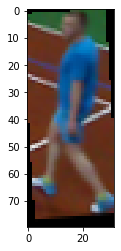

In [90]:
for image in list(image_cache.values())[53:55]:
    image1 = datagens[0].random_transform(image)
    plt.imshow(image1)
    

In [92]:
BATCH_SIZE = 64
VAL_BATCH_SIZE = 128
NUM_EPOCHS = 1
BEST_MODEL_FILE = os.path.join(DATA_DIR, "models", "best.h5")
FINAL_MODEL_FILE  = os.path.join(DATA_DIR, "models", "final.h5")
CHECKPOINT = os.path.join(DATA_DIR, "models", "model.{epoch:03d}-{loss:.4f}-{accuracy:.3f}-{val_loss:.4f}-{val_accuracy:.3f}.h5")
LATEST_MODEL = 'm3_latest.h5'

datagen_args = dict(rotation_range=10,
                    width_shift_range=2,
                    height_shift_range=2,
                    zoom_range=0.)
datagens = [ImageDataGenerator(**datagen_args),
            ImageDataGenerator(**datagen_args)]

train_pair_gen = pair_generator(pos_triplets, neg_triplets, image_cache, datagens, BATCH_SIZE)
val_pair_gen = pair_generator(val_pos_triplets, val_neg_triplets, val_image_cache, [ImageDataGenerator(),ImageDataGenerator()], VAL_BATCH_SIZE)
num_train_steps = len(pos_triplets) // BATCH_SIZE * 4
num_val_steps = len(val_pos_triplets) // VAL_BATCH_SIZE * 4
assert num_val_steps > 0

In [213]:
len(val_pos_triplets)

171

In [95]:
from keras.models import load_model
#model = load_model('m3.h5')
model = load_model('./model.133-0.6293-0.650-0.6689-0.553.h5')

In [180]:

model.load_weights(LATEST_MODEL)

In [97]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath=CHECKPOINT, save_best_only=True)
import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'//'
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history1 = model.fit_generator(train_pair_gen, 
                             steps_per_epoch=num_train_steps,
                             epochs=1,#NUM_EPOCHS,
                             validation_data=val_pair_gen,
                             validation_steps=num_val_steps,
                             callbacks=[checkpoint])

Epoch 1/1
248/248 [==============================] - 117s 471ms/step - loss: 0.6728 - accuracy: 0.5945 - val_loss: 0.6958 - val_accuracy: 0.5293


In [ ]:
model.summary()

In [178]:
model.save('m3_latest.h5')

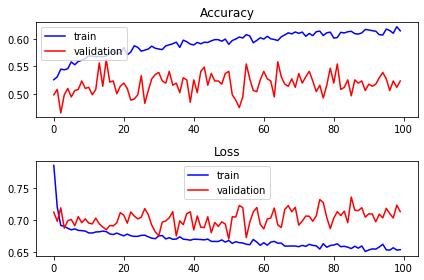

In [219]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["accuracy"], color="blue", label="train")
plt.plot(history.history["val_accuracy"], color="red", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="blue", label="train")
plt.plot(history.history["val_loss"], color="red", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [127]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [168]:
import tensorflow.python.keras.backend as K
K.eval(model.optimizer.lr)

0.05

In [110]:
from keras.callbacks import ReduceLROnPlateau
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=10, patience=5)

ValueError: ReduceLROnPlateau does not support a factor >= 1.0.

In [143]:
all_files=[]
sub_dirs_dict ={}
sub_dirs = [f.name for f in os.scandir(IMAGE_DIR) if f.is_dir()]
for sd in sub_dirs:
    sub_dirs_dict[sd] =  [f.name for f in os.scandir(os.path.join(IMAGE_DIR, sd)) if f.is_file() ]
    all_files.extend([f.path for f in os.scandir(os.path.join(IMAGE_DIR, sd)) if f.is_file()])
for k, v in sub_dirs_dict.items():
    if len(v) < 10:
        print(k, len(v))


Андрей _28 0
Николай _30 0


In [53]:
from tensorflow.python.keras.optimizers import Adam
adam = Adam(lr=0.0005, epsilon = 1e-8, beta_1 = .9, beta_2 = .999)
model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])

In [56]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [174]:
from tensorflow.python.keras import models , optimizers , losses ,activations , callbacks
from tensorflow.python.keras.layers import *
import tensorflow.python.keras.backend as K
import tensorflow as tf
import keras
from keras.initializers import glorot_uniform
from tensorflow.keras.models import load_model
model = load_model('model.h5')

In [291]:
model.layers

In [172]:
import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        model = load_model('model.h5')

TypeError: ('Keyword argument not understood:', 'module')

True

In [187]:
from keras.applications.densenet import DenseNet121

densenet = DenseNet121()


True

In [192]:
densenet.layers[-2].output

<tf.Tensor 'avg_pool_2/Mean:0' shape=(None, 1024) dtype=float32>